In [72]:
using CSV, DataFrames, Plots, Statistics, JuMP, Gurobi, StatsBase

In [73]:
pollution = DataFrame(CSV.File("Data/pollution_location.csv"))
pollution_xy = pollution[:,1:2]|>Matrix
densities = DataFrame(CSV.File("Data/density_location.csv"))
sensors = DataFrame(CSV.File("Data/sensors_location.csv"))
sensors_xy = sensors[:,1:2]|>Matrix;

In [74]:
lat_to_km = [111, 92]
lat_diff = (pollution_xy[:,1].-sensors_xy[:,1]').*lat_to_km[1]
long_diff = (pollution_xy[:,2].-sensors_xy[:,2]').*lat_to_km[2]

dist_matrix = sqrt.(lat_diff.^2 + long_diff.^2)';
rows_to_keep = findall(row -> any(iszero, row), eachrow(dist_matrix))
dist_matrix = dist_matrix[rows_to_keep, :]
sensors_xy = sensors_xy[rows_to_keep, :];

In [75]:
density

Row,latitude,longitude,density
,Float64,Float64,Float64
1,33.7082,-118.287,1.30231
2,33.7191,-118.323,1.55719
3,33.7191,-118.314,1.547
4,33.7191,-118.305,1.48912
5,33.7191,-118.296,1.43123
6,33.7191,-118.287,1.37335
7,33.7191,-118.251,1.35686
8,33.73,-118.35,1.40214
9,33.73,-118.341,1.46163


In [76]:
dens = densities.density
dens = max.(dens,0.333)
r1 = 0
r2 = 3
r3 = 10
d1 = ((dist_matrix' .* dens)' .<= r1)
d2 = (r1 .< (dist_matrix' .* dens)' .<= r2)
d3 = (r2 .< (dist_matrix' .* dens)' .<= r3)
q = pollution.AIQ

n, m = size(dist_matrix)

(1780, 7107)

In [77]:
function model1b()
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "TimeLimit", 120);
    
    @variable(model, x[1:n], Bin) #Whether we put a sensor at spot i
    @variable(model, y1[1:m].<=1) #Whether spot j is covered closely
    @variable(model, y2[1:m].<=1) #Whether spot j is covered at a distance
    @variable(model, y3[1:m].<=1) #Whether spot j is covered at a distance
    
    @constraint(model, y1'.<= x'*d1)
    @constraint(model, y2'.<= x'*d2)
    @constraint(model, y3'.<= x'*d3)
    @constraint(model, y1 .+ y2 .+ y3 .<=1)
    @constraint(model, sum(x)<=348) # Check this number
    
    @objective(model, Max, sum(y1.*q) + 1/8*sum(y2.*q) + 1/200*sum(y3.*q))
    optimize!(model)
    return value.(x), value.(y1), value.(y2), value.(y3)
end
x, y1, y2, y3 = model1b()
sum(x)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28429 rows, 23101 columns and 1795447 nonzeros
Model fingerprint: 0xd397e95c
Variable types: 21321 continuous, 1780 integer (1780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 7551 rows and 7454 columns
Presolve time: 1.42s
Presolved: 20878 rows, 15647 columns, 1780442 nonzeros
Variable types: 13545 continuous, 2102 integer (2102 binary)
Found heuristic solution: objective 22681.318013
Deterministic concurrent LP optimizer: primal and dual 

348.0

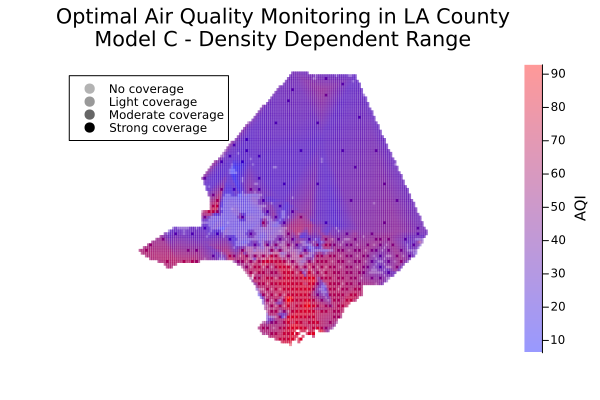

In [80]:
scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=q, 
    color=cgrad([:blue, :red]), 
    alpha= .3 .+ 0.7 .* y1 + 0.3 .* y2 + 0.1 .* y3 ,
    markersize=1.5, 
    shape=:rect,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = false, grid = false,
    )

scatter!([NaN], [NaN], alpha = 0.3, color = :black, shape = :circle, label = "No coverage")
scatter!([NaN], [NaN], alpha = 0.4, color = :black, shape = :circle, label = "Light coverage")
scatter!([NaN], [NaN], alpha = 0.6, color = :black, shape = :circle, label = "Moderate coverage")
scatter!([NaN], [NaN], alpha = 1, color = :black, shape = :circle, label = "Strong coverage")


# Add a title with better formatting
title!("Optimal Air Quality Monitoring in LA County\nModel C - Density Dependent Range")